# Homework 5
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers K-Means and HAC methods for clustering.

In [2]:
# Setup
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **Clustering algorithms**: Implement K-Means clustering and Hierarchical Agglomerative Clustering.
- **Pixel-level features**: Implement a feature vector that combines color and position information and implement feature normalization.
- **Quantitative Evaluation**: Evaluate segmentation algorithms with a variety of parameter settings by comparing your computed segmentations against a dataset of ground-truth segmentations.

## 1 Clustering Algorithms (40 points)

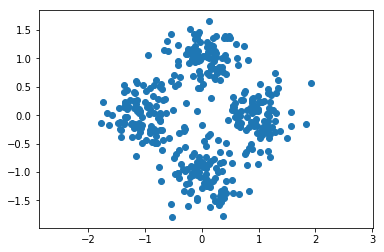

In [5]:
# Generate random data points for clustering

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))
# x, y = np.meshgrid(np.arange(0,3),np.arange(0,3)) #for testing
# x, y = x.reshape((9,1)), y.reshape((9,1))
# X = np.hstack((x,y))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (20 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested for loops to assign points to the closest centroid and compute new mean of each cluster.

total turns:  4
kmeans running time: 0.003003 seconds.


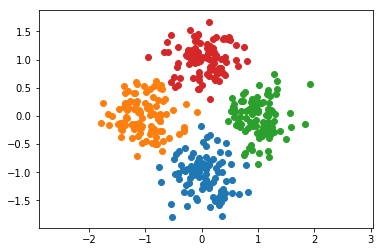

In [12]:
from segmentation import kmeans

np.random.seed(int(time()))
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()


We can use numpy functions and broadcasting to make kmeans faster. Implement **`kmeans_fast`** in `segmentation.py`. This should run at least 10 times faster than the previous implementation.

In [13]:
from segmentation import kmeans_fast

np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

kmeans running time: 0.000000 seconds.


ZeroDivisionError: float division by zero

### 1.2 Hierarchical Agglomerative Clustering (20 points)
Another simple clustering algorithm is Hieararchical Agglomerative Clustering, which is somtimes abbreviated as HAC. In this algorithm, each point is initially assigned to its own cluster. Then cluster pairs are merged until we are left with the desired number of predetermined clusters (see Algorithm 1).

Implement **`hiererachical_clustering`** in `segmentation.py`.

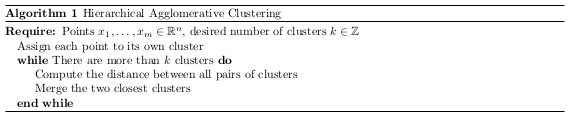

hierarchical_clustering running time: 0.296754 seconds.


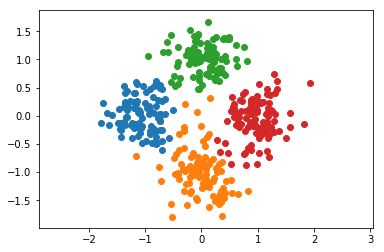

In [14]:
from segmentation import hierarchical_clustering
from segmentation_his import hierarchical_clustering as hierarchical_clustering1

start = time()
assignments = hierarchical_clustering1(X, 4)
end = time()

print("hierarchical_clustering running time: %f seconds." % (end - start))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

## 2 Pixel-Level Features (30 points)
Before we can use a clustering algorithm to segment an image, we must compute some *feature vectore* for each pixel. The feature vector for each pixel should encode the qualities that we cae about in a good segmentation. More concretely, for a pair of pixels $p_i$ and $p_j$ with corresponding feature vectors $f_i$ and $f_j$, the distance between $f_i$ and $f_j$ should be small if we believe that $p_i$ and $p_j$ should be placed in the same segment and large otherwise.

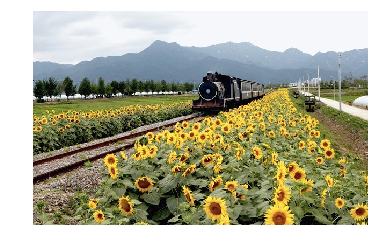

In [71]:
# Load and display image
img = io.imread('train.jpg')
H, W, C = img.shape

plt.imshow(img)
plt.axis('off')
plt.show()

### 2.1 Color Features (15 points)
One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. Implement **`color_features`** in `segmentation.py`. Output should look like the following:
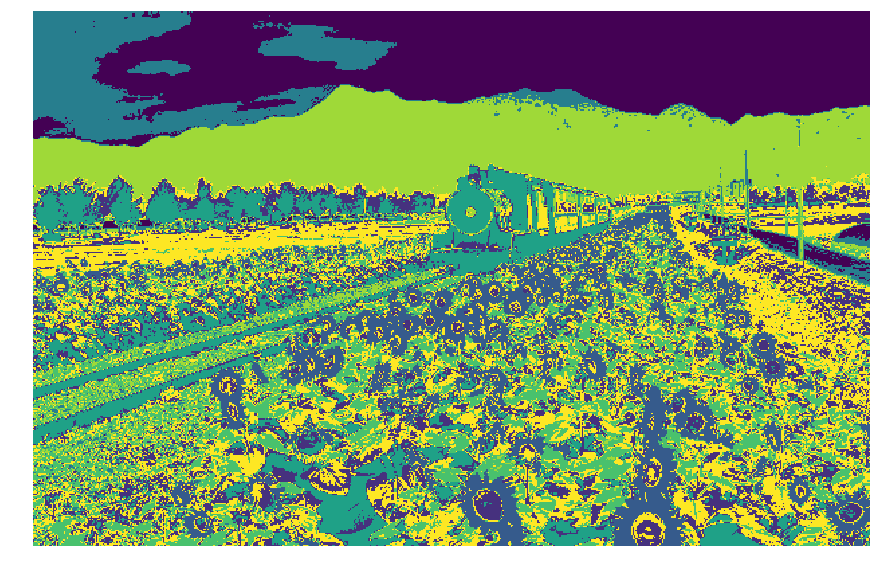

(8, 3) (248976, 3)
total turns:  27
(8, 248976)


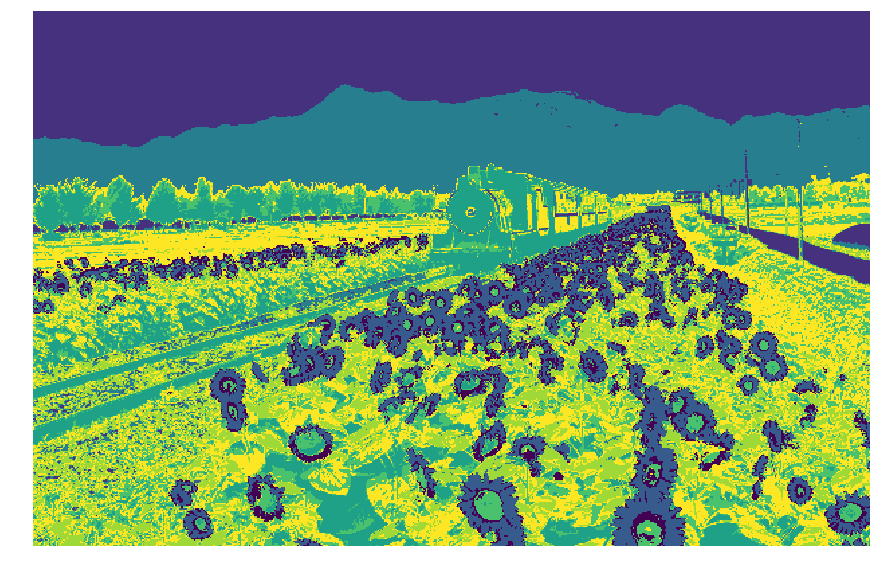

In [88]:
from segmentation import color_features
np.random.seed(int(time()) % 1000)

features = color_features(img)

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In the cell below, we visualize each segment as the mean color of pixels in the segment.

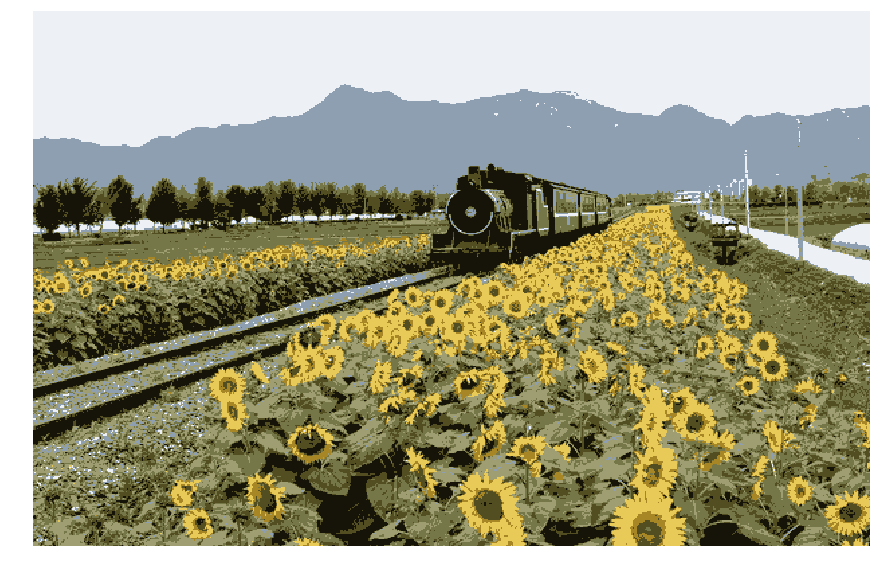

In [89]:
from utils import visualize_mean_color_image
visualize_mean_color_image(img, segments)

### 2.2 Color and Position Features (15 points)
Another simple feature vector for a pixel is to concatenate its color and position within the image. In other words, for a pixel of color $(r, g, b)$ located at position $(x, y)$ in the image, its feature vector would be $(r, g, b, x, y)$. However, the color and position features may have drastically different ranges; for example each color channel of an image may be in the range $[0, 1)$, while the position of each pixel may have a much wider range. Uneven scaling between different features in the feature vector may cause clustering algorithms to behave poorly.

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Implement **`color_position_features`** in `segmentation.py`.

Output segmentation should look like the following:
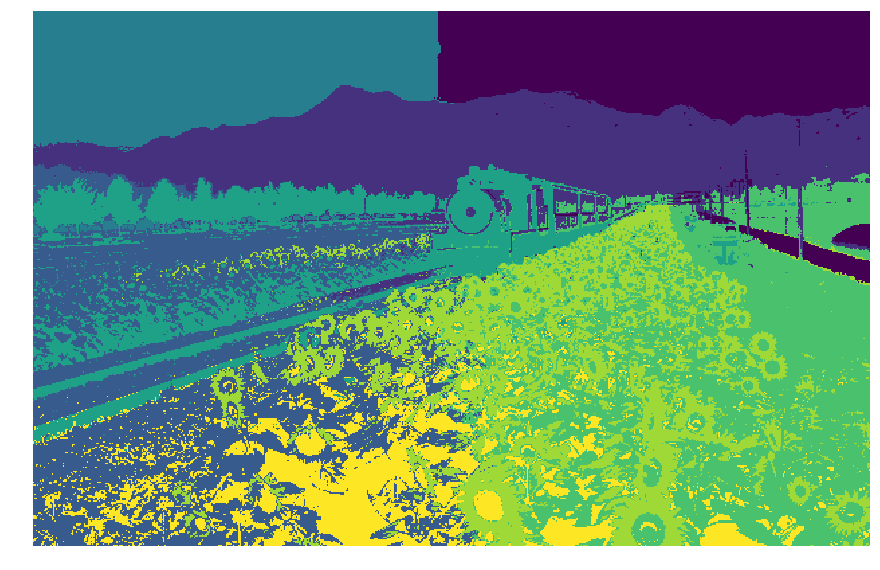

(8, 5) (248976, 5)
total turns:  36
(8, 248976)


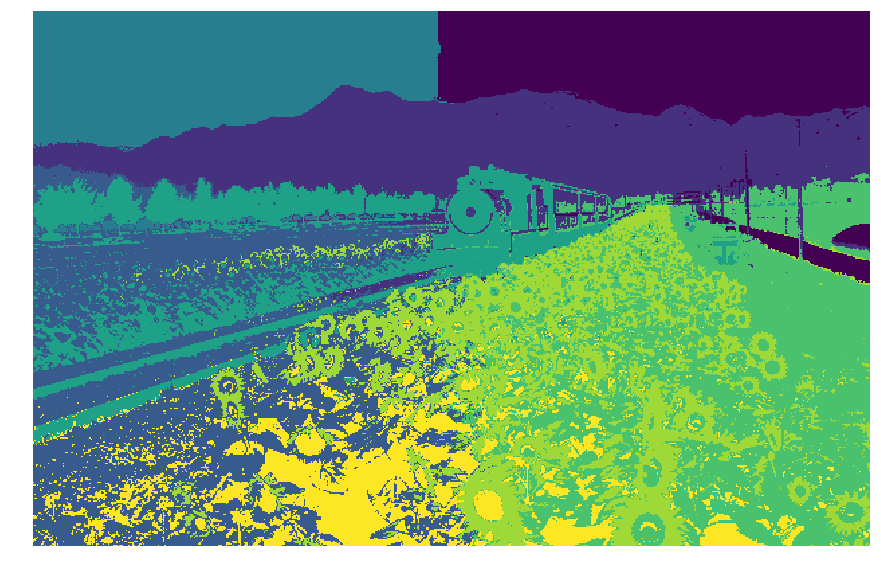

In [114]:
from segmentation import color_position_features
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

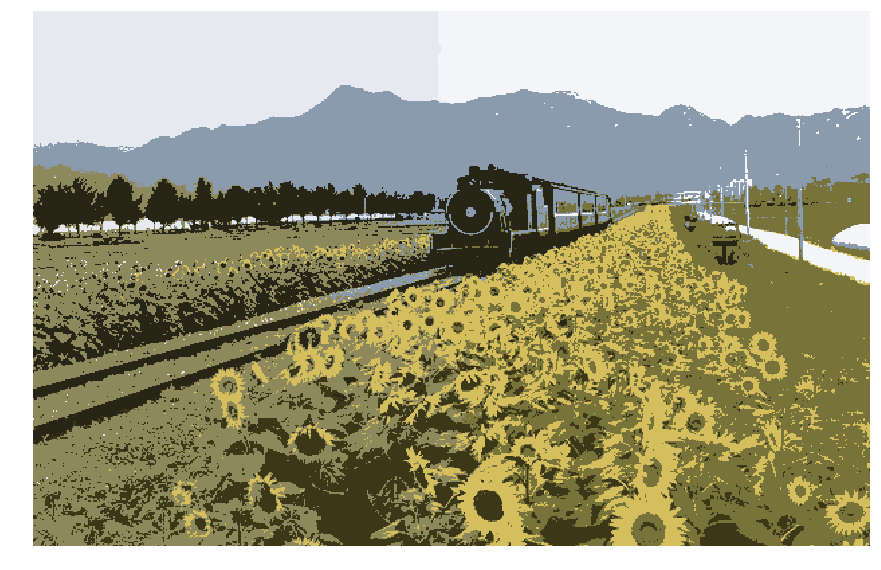

In [115]:
visualize_mean_color_image(img, segments)

### Extra Credit: Implement Your Own Feature
For this programming assignment we have asked you to implement a very simple feature transform for each pixel. While it is not required, you should feel free to experiment with other feature transforms. Could your final segmentations be improved by adding gradients, edges, SIFT descriptors, or other information to your feature vectors? Could a different type of normalization give better results?

Implement your feature extractor **`my_features`** in `segmentation.py`

Depending on the creativity of your approach and the quality of your writeup, implementing extra feature vectors can be worth extra credit (up to 5% of total points).

**Describe your approach**: (YOUR APPROACH)

In [ ]:
from segmentation import my_features

# Feel free to experiment with different images
# and varying number of segments
img = io.imread('train.jpg')
num_segments = 8

H, W, C = img.shape

# Extract pixel-level features
features = my_features(img)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

## 3 Quantitative Evaluation (30 points)

Looking at images is a good way to get an idea for how well an algorithm is working, but the best way to evaluate an algorithm is to have some quantitative measure of its performance.

For this project we have supplied a small dataset of cat images and ground truth segmentations of these images into foreground (cats) and background (everything else). We will quantitatively evaluate different segmentation methods (features and clustering methods) on this dataset.

We can cast the segmentation task into a binary classification problem, where we need to classify each pixel in an image into either foreground (positive) or background (negative). Given the ground-truth labels, the accuracy of a segmentation is $(TP+TN)/(P+N)$.

Implement **`compute_accuracy`** in `segmentation.py`.

Accuracy: 0.97


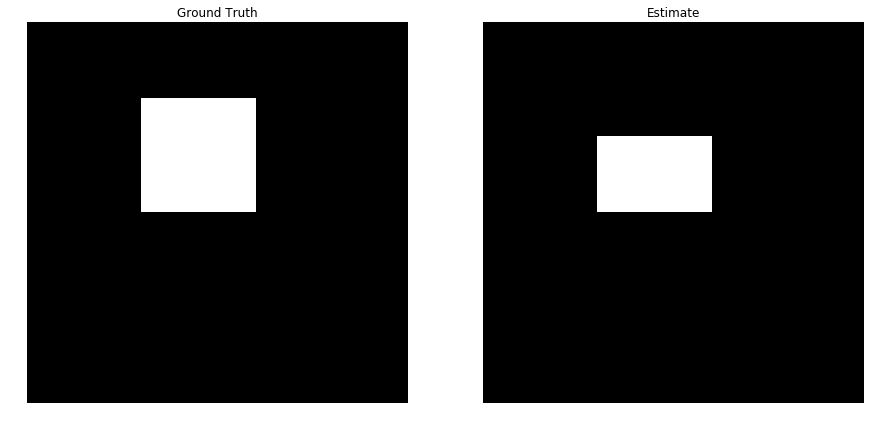

In [136]:
from segmentation import compute_accuracy

mask_gt = np.zeros((100, 100))
mask = np.zeros((100, 100))

# Test compute_accracy function
mask_gt[20:50, 30:60] = 1
mask[30:50, 30:60] = 1

accuracy = compute_accuracy(mask_gt, mask)

print('Accuracy: %0.2f' % (accuracy))
if accuracy != 0.97:
    print('Check your implementation!')

plt.subplot(121)
plt.imshow(mask_gt)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Estimate')
plt.axis('off')

plt.show()

In [148]:
print(type(features))
print(H, W, C)
print((399*624)*8)
from scipy.spatial.distance import cdist
cdist(np.array([[1,2],[3,4]]),np.array([[5,6]]))
features = color_features(img)

a = np.ones((5,1))
b = np.ones((5,1))
np.hstack((a,b))
c = np.arange(10).reshape(2,5)
print(c)
print(gt_mask.max(), gt_mask.min())

<class 'numpy.ndarray'>
399 624 3
1991808
[[0 1 2 3 4]
 [5 6 7 8 9]]
1 0


You can use the script below to evaluate a segmentation method’s ability to separate foreground from background on the entire provided dataset. Use this script as a starting point to evaluate a variety of segmentation parameters.

In [141]:
from utils import load_dataset, compute_segmentation
from segmentation import evaluate_segmentation

# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./data')

# Set the parameters for segmentation.
num_segments = 3
clustering_fn = kmeans
feature_fn = color_features
scale = 0.5

mean_accuracy = 0.0

segmentations = []

for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
    # Compute a segmentation for this image
    segments = compute_segmentation(img, num_segments,
                                    clustering_fn=clustering_fn,
                                    feature_fn=feature_fn,
                                    scale=scale)
    
    segmentations.append(segments)
    
    # Evaluate segmentation
    accuracy = evaluate_segmentation(gt_mask, segments)
    
    print('Accuracy for image %d: %0.4f' %(i, accuracy))
    mean_accuracy += accuracy
    
mean_accuracy = mean_accuracy / len(imgs)
print('Mean accuracy: %0.4f' % mean_accuracy)

d:\anaconda3 4.2.0\envs\py3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


total turns:  10
Accuracy for image 0: 0.8094
total turns:  9
Accuracy for image 1: 0.9587
total turns:  4
Accuracy for image 2: 0.9860
total turns:  21
Accuracy for image 3: 0.9069
total turns:  11
Accuracy for image 4: 0.9782
total turns:  14
Accuracy for image 5: 0.6979
total turns:  10
Accuracy for image 6: 0.6700
total turns:  14
Accuracy for image 7: 0.6625
total turns:  12
Accuracy for image 8: 0.8366
total turns:  9
Accuracy for image 9: 0.9536
total turns:  12
Accuracy for image 10: 0.8705
total turns:  8
Accuracy for image 11: 0.8114
total turns:  10
Accuracy for image 12: 0.7335
total turns:  20
Accuracy for image 13: 0.6628
total turns:  6
Accuracy for image 14: 0.7495
total turns:  15
Accuracy for image 15: 0.5040
Mean accuracy: 0.7995


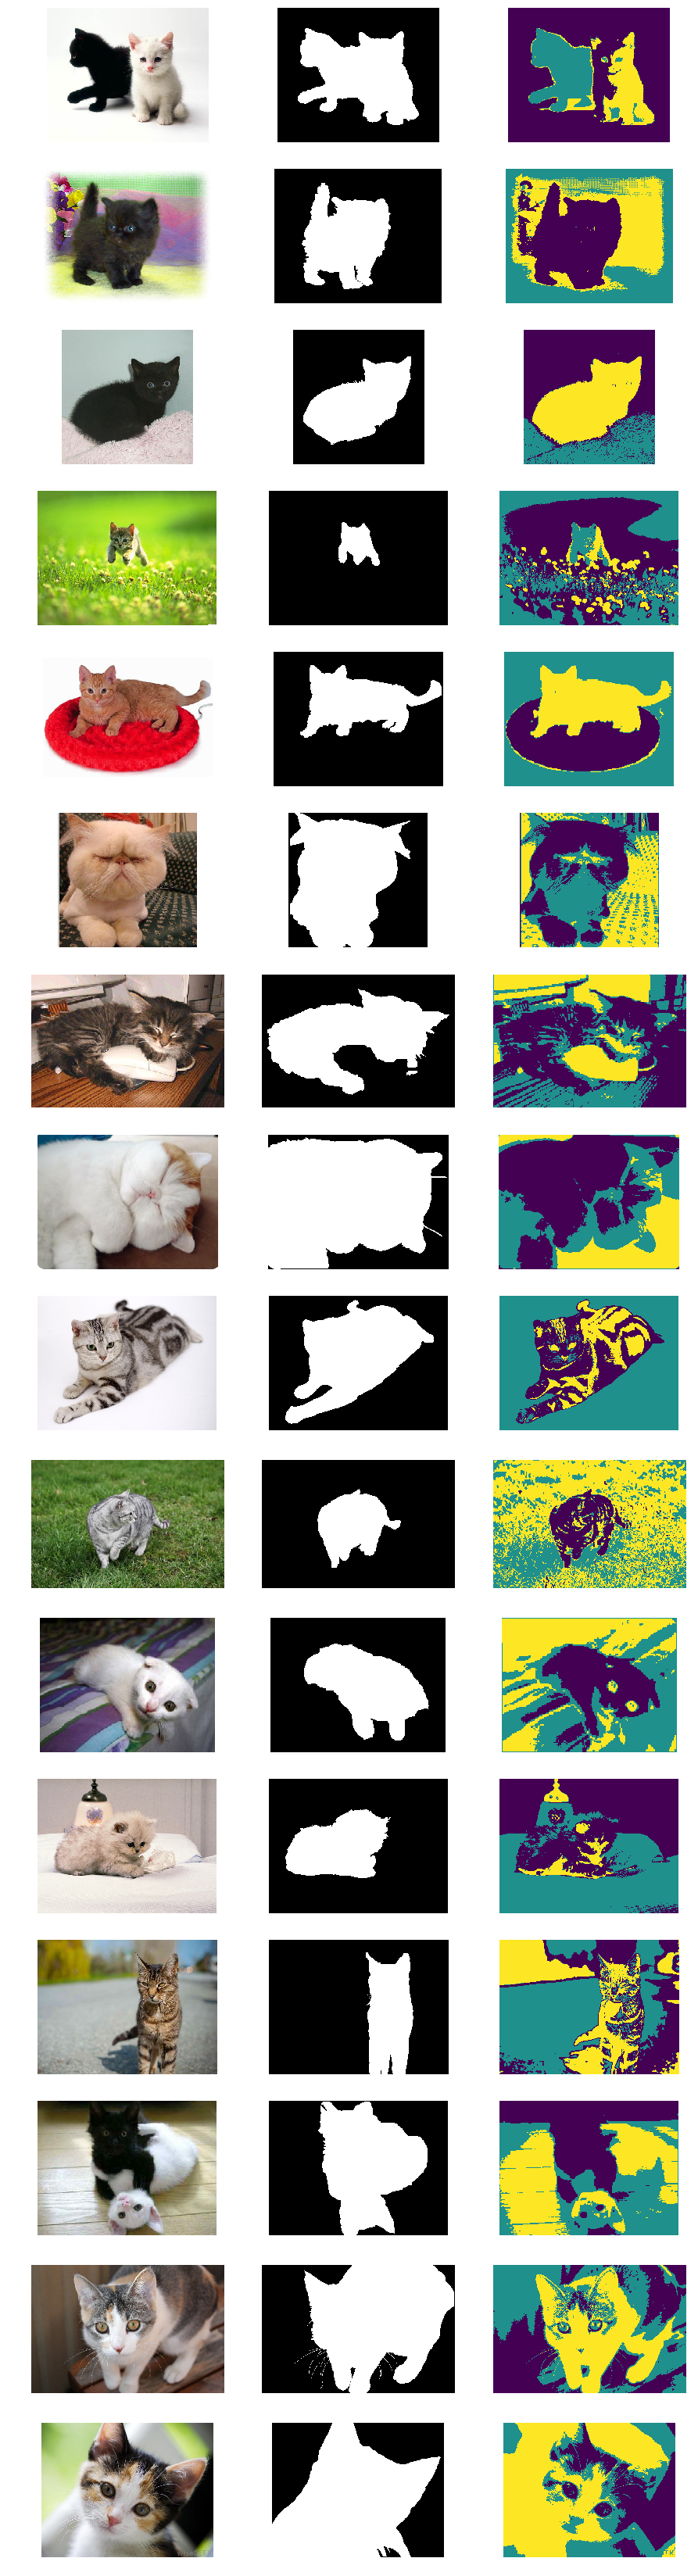

In [142]:
# Visualize segmentation results

N = len(imgs)
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(gt_masks[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 3)
    plt.imshow(segmentations[i], cmap='viridis')
    plt.axis('off')

plt.show()

Include a detailed evaluation of the effect of varying segmentation parameters (feature transform, clustering method, number of clusters, resize) on the mean accuracy of foreground-background segmentations on the provided dataset. You should test a minimum of 10 combinations of parameters. To present your results, add rows to the table below (you may delete the first row).

 <table style="width:100%">
  <tr>
    <th>Feature Transform</th>
    <th>Clustering Method</th>
    <th>Number of segments</th>
    <th>Scale</th>
    <th>Mean Accuracy</th>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.58</td>
  </tr>
   <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table> 

Observe your results carefully and try to answer the following question:
1. Based on your quantitative experiments, how do each of the segmentation parameters affect the quality of the final foreground-background segmentation?
2. Are some images simply more difficult to segment correctly than others? If so, what are the qualities of these images that cause the segmentation algorithms to perform poorly?
3. Also feel free to point out or discuss any other interesting observations that you made.

Write your analysis in the cell below.

**Your answer here**: